In [1]:
import os
from os import getcwd
import shutil
from shutil import copyfile
import zipfile
from google.colab import drive

In [2]:
drive.mount('/gdrive')

Mounted at /gdrive


In [11]:
shutil.rmtree('/gdrive/MyDrive/ObjectDetection')

In [2]:
CUSTOM_MODEL_NAME = "my_ssd_MobileNet"
PRETRAINED_MODEL_NAME = "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
PRETRAINED_MODEL_URL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
TF_RECORD_SCRIPT = "generate_tfrecord.py"
LABEL_MAP_NAME = "label_map.pbtxt"

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace'),
    'SRC_PATH': os.path.join('/gdrive/MyDrive/', 'dataset.zip'),
    'SCRIPTS_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'scripts'),
    'APIMODEL_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'models'),
    'ANNOTATION_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace', 'annotations'),
    'IMAGE_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace', 'images'),
    'RESULT_IMAGES_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'results', 'Images'),
    'RESULT_PLOTS_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'results', 'Plots'),
    'PRETRAINED_MODEL_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace', 'models', CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'),
    'TFLITE_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH': os.path.join('/gdrive/MyDrive/ObjectDetection', 'protoc')
}

In [4]:
files = {
    'PIPELINE_CONFIG': os.path.join('/gdrive/MyDrive/ObjectDetection', 'workspace', 'models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT),
    'LABEL_MAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [15]:
for path in paths.values():
  if not os.path.exists(path):
    if os.name == 'posix':
      !mkdir -p {path}
    if os.name == 'nt':
      !mkdir {path}
  else:
    print('Path already exists')

Path already exists


#step:1
- download tensorflow object detection API and set up some path
- verify object detection API

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object detection')):
  !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
else:
  print('This path already exists')

In [ ]:
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd /gdrive/MyDrive/ObjectDetection/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd gdrive/MyDrive/ObjectDetection/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd gdrive/MyDrive/ObjectDetection/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [19]:
!pip install tensorflow --upgrade

In [ ]:
!pip list

#step:2 
- download a pretraind model e,g. SSDmobileNetV2

In [ ]:
if os.name == 'posix':
  !wget {PRETRAINED_MODEL_URL}
  !mv {PRETRAINED_MODEL_NAME + '.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
  !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME + '.tar.gz'}
if os.name == 'nt':
  wget.download(PRETRAINED_MODEL_URL)
  !mv {PRETRAINED_MODEL_NAME + '.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
  !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME + '.tar.gz'}

#Step:3
- create label map for the dataset

In [5]:
labels = [{'name': 'ThumbsUp', 'id':1}, {'name': 'ThumbsDown', 'id':2},
          {'name': 'ThankYou', 'id':3}, {'name': 'LiveLong', 'id':4}]
with open(files['LABEL_MAP'], 'w') as f:
  for label in labels:
    f.write('item{\n')
    f.write('\tname:\'{}\'\n'.format(label['name']))
    f.write('\tid:{}\n'.format(label['id']))
    f.write('}\n')

#step:4 
- create tensorflow record files for training

In [22]:
#copy dataset.zip file to IMAGES_PATH
copyfile(paths['SRC_PATH'], os.path.join(paths['IMAGE_PATH'], 'dataset.zip'))

'/gdrive/MyDrive/ObjectDetection/workspace/images/dataset.zip'

In [23]:
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'dataset.zip')
if os.path.exists(ARCHIVE_FILES):
  zip_ref = zipfile.ZipFile(ARCHIVE_FILES, 'r')
  zip_ref.extractall(paths['IMAGE_PATH'])
  zip_ref.close()
  


In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
  !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}


In [25]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'dataset', 'train')} -l {files['LABEL_MAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'dataset', 'test')} -l {files['LABEL_MAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

2022-02-14 12:52:24.413575: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecord file: /gdrive/MyDrive/ObjectDetection/workspace/annotations/train.record
2022-02-14 12:52:28.808301: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecord file: /gdrive/MyDrive/ObjectDetection/workspace/annotations/test.record


#step:5
- copy model config to training folder

In [26]:
if os.name == 'posix':
  !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config' )} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
  !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

#Step:6
- update config for transfer learning

In [ ]:
!pip install numpy --upgrade --ignore-installed


In [ ]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

In [7]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [8]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], 'r') as f:
  proto_str = f.read()
  text_format.Merge(proto_str, pipeline_config)

In [ ]:
pipeline_config

In [10]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = files['LABEL_MAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'],'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABEL_MAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
pipeline_config

In [11]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [12]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [13]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [16]:
print(command)

python /gdrive/MyDrive/ObjectDetection/models/research/object_detection/model_main_tf2.py --model_dir=/gdrive/MyDrive/ObjectDetection/workspace/models/my_ssd_MobileNet --pipeline_config_path=/gdrive/MyDrive/ObjectDetection/workspace/models/my_ssd_MobileNet/pipeline.config --num_train_steps=2000


In [14]:
!{command}

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
2022-02-14 12:54:25.841559: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W0214 12:54:25.843357 140536982017920 cross_device_ops.py:1386] There are non-GPU devices in `tf.distribute.Strategy`, not

In [15]:
import os
import tensorflow as tf


from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [17]:
#load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training = False)

#Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths["CHECKPOINT_PATH"], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
  image, shapes = detection_model.preprocess(image)
  prediction_dict = detection_model.predict(image, shapes)
  detections = detection_model.postprocess(prediction_dict, shapes)
  return detections


In [18]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABEL_MAP'])

In [42]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'dataset', 'test', 'livelong.212985b0-881e-11ec-9843-9822ef898636.jpg')


In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype= tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, : num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)



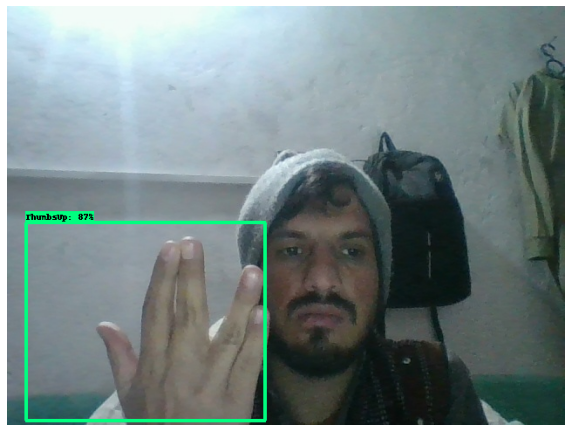

In [44]:

plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [50]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)